In [2]:
import numpy as np
import os
import pandas as pd
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,VotingClassifier
from sklearn.linear_model import SGDRegressor, LinearRegression, BayesianRidge, Lasso, HuberRegressor, ElasticNetCV
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
sns.set(color_codes=True)
from scipy import stats
from scipy.stats import norm, skew #for some statistics
import xgboost as xgb
import lightgbm as lgb
np.random.seed(25)

In [3]:
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

In [4]:
train.head()

,PRT_ID,AREA,INT_SQFT,DATE_SALE,DIST_MAINROAD,N_BEDROOM,N_BATHROOM,N_ROOM,SALE_COND,PARK_FACIL,...,UTILITY_AVAIL,STREET,MZZONE,QS_ROOMS,QS_BATHROOM,QS_BEDROOM,QS_OVERALL,REG_FEE,COMMIS,SALES_PRICE
0,P03210,Karapakkam,1004,04-05-2011,131,1.0,1.0,3,AbNormal,Yes,...,AllPub,Paved,A,4.0,3.9,4.9,4.330,380000,144400,7600000
1,P09411,Anna Nagar,1986,19-12-2006,26,2.0,1.0,5,AbNormal,No,...,AllPub,Gravel,RH,4.9,4.2,2.5,3.765,760122,304049,21717770
2,P01812,Adyar,909,04-02-2012,70,1.0,1.0,3,AbNormal,Yes,...,ELO,Gravel,RL,4.1,3.8,2.2,3.090,421094,92114,13159200
3,P05346,Velachery,1855,13-03-2010,14,3.0,2.0,5,Family,No,...,NoSewr,Paved,I,4.7,3.9,3.6,4.010,356321,77042,9630290
4,P06210,Karapakkam,1226,05-10-2009,84,1.0,1.0,3,AbNormal,Yes,...,AllPub,Gravel,C,3.0,2.5,4.1,3.290,237000,74063,7406250


In [5]:
train['N_BEDROOM'].value_counts()

1.0    3795
2.0    2352
3.0     707
4.0     254
Name: N_BEDROOM, dtype: int64

In [6]:
train.dtypes

PRT_ID            object
AREA              object
INT_SQFT           int64
DATE_SALE         object
DIST_MAINROAD      int64
N_BEDROOM        float64
N_BATHROOM       float64
N_ROOM             int64
SALE_COND         object
PARK_FACIL        object
DATE_BUILD        object
BUILDTYPE         object
UTILITY_AVAIL     object
STREET            object
MZZONE            object
QS_ROOMS         float64
QS_BATHROOM      float64
QS_BEDROOM       float64
QS_OVERALL       float64
REG_FEE            int64
COMMIS             int64
SALES_PRICE        int64
dtype: object

In [7]:
train.isnull().sum(axis=0)

PRT_ID            0
AREA              0
INT_SQFT          0
DATE_SALE         0
DIST_MAINROAD     0
N_BEDROOM         1
N_BATHROOM        5
N_ROOM            0
SALE_COND         0
PARK_FACIL        0
DATE_BUILD        0
BUILDTYPE         0
UTILITY_AVAIL     0
STREET            0
MZZONE            0
QS_ROOMS          0
QS_BATHROOM       0
QS_BEDROOM        0
QS_OVERALL       48
REG_FEE           0
COMMIS            0
SALES_PRICE       0
dtype: int64

In [8]:
train = train.fillna({"N_BEDROOM": train["N_BEDROOM"].mean(), "INT_SQFT": train["INT_SQFT"].mean(),
                     "N_BATHROOM": train["N_BATHROOM"].mean(), "QS_OVERALL": train["QS_OVERALL"].mean()})
test = test.fillna({"N_BEDROOM": test["N_BEDROOM"].mean(), "INT_SQFT": train["INT_SQFT"].mean(),
                     "N_BATHROOM": test["N_BATHROOM"].mean(), "QS_OVERALL": test["QS_OVERALL"].mean()})

In [ ]:
# train['N_BEDROOM'] = train['N_BEDROOM'].astype(int)
# test['N_BEDROOM'] = test['N_BEDROOM'].astype(int)

# train['N_BATHROOM'] = train['N_BATHROOM'].astype(int)
# test['N_BATHROOM'] = test['N_BATHROOM'].astype(int)

# Feature Engineering

In [9]:
train['diff_reg_comm'] = train['REG_FEE'] - train['COMMIS']
test['diff_reg_comm'] = test['REG_FEE'] - test['COMMIS']

In [10]:
def get_month(x):
    txt = str(x)
    y = txt.split('-')
    if len(y) != 3:
        return 'None'
    return int(y[1])

def get_year(x):
    txt = str(x)
    y = txt.split('-')
    if len(y) != 3:
        return 'None'
    return int(y[2])

In [11]:
train['MONTH'] = train['DATE_SALE'].map(lambda x: get_month(x))
train['YEAR'] = train['DATE_SALE'].map(lambda x: get_year(x))

test['MONTH'] = test['DATE_SALE'].map(lambda x: get_month(x))
test['YEAR'] = test['DATE_SALE'].map(lambda x: get_year(x))

In [12]:
train['DATE_SALE'] = pd.to_datetime(train['DATE_SALE'].astype(str), format='%d-%m-%Y')
train['DATE_BUILD'] = pd.to_datetime(train['DATE_BUILD'].astype(str), format='%d-%m-%Y')

test['DATE_SALE'] = pd.to_datetime(test['DATE_SALE'].astype(str), format='%d-%m-%Y')
test['DATE_BUILD'] = pd.to_datetime(test['DATE_BUILD'].astype(str), format='%d-%m-%Y')

In [13]:
train['HOUSE_LIFETIME'] = train['DATE_SALE'] .subtract( train['DATE_BUILD'])
test['HOUSE_LIFETIME'] = test['DATE_SALE'] .subtract( test['DATE_BUILD'])

train['HOUSE_LIFETIME'] = train['HOUSE_LIFETIME'] .divide( np.timedelta64(1, 'D'))
test['HOUSE_LIFETIME'] = test['HOUSE_LIFETIME'] .divide( np.timedelta64(1, 'D'))

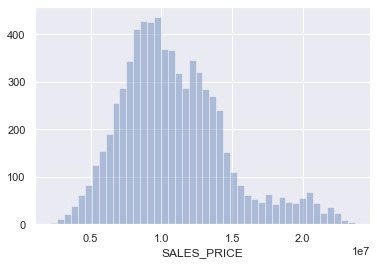

In [14]:
sns.distplot(train['SALES_PRICE'] , kde=False);

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


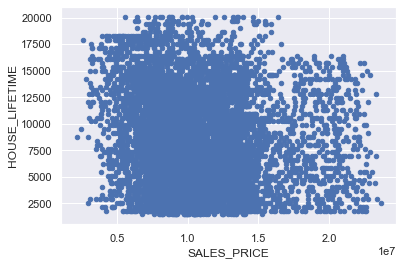

In [15]:
var = 'SALES_PRICE'
data = pd.concat([train['HOUSE_LIFETIME'], train[var]], axis=1)
data.plot.scatter(x=var, y='HOUSE_LIFETIME');        # ylim=(0,2500)

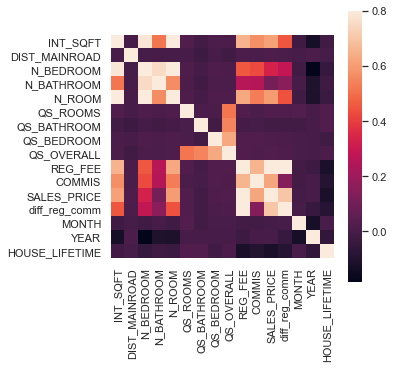

In [16]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(corrmat, vmax=.8, square=True);

In [17]:
feature_names = [x for x in train.columns if x not in ['PRT_ID','SALES_PRICE','DATE_SALE','DATE_BUILD']]
target = train['SALES_PRICE']

In [ ]:
# One-hot encoding
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
train["AREA"] = lb_make.fit_transform(train["AREA"])
test["AREA"] = lb_make.fit_transform(test["AREA"])

train["SALE_COND"] = lb_make.fit_transform(train["SALE_COND"])
test["SALE_COND"] = lb_make.fit_transform(test["SALE_COND"])

train["PARK_FACIL"] = lb_make.fit_transform(train["PARK_FACIL"])
test["PARK_FACIL"] = lb_make.fit_transform(test["PARK_FACIL"])

train["BUILDTYPE"] = lb_make.fit_transform(train["BUILDTYPE"])
test["BUILDTYPE"] = lb_make.fit_transform(test["BUILDTYPE"])

train["UTILITY_AVAIL"] = lb_make.fit_transform(train["UTILITY_AVAIL"])
test["UTILITY_AVAIL"] = lb_make.fit_transform(test["UTILITY_AVAIL"])

train["STREET"] = lb_make.fit_transform(train["STREET"])
test["STREET"] = lb_make.fit_transform(test["STREET"])

train["MZZONE"] = lb_make.fit_transform(train["MZZONE"])
test["MZZONE"] = lb_make.fit_transform(test["MZZONE"])

In [18]:
train[feature_names].dtypes

AREA               object
INT_SQFT            int64
DIST_MAINROAD       int64
N_BEDROOM         float64
N_BATHROOM        float64
N_ROOM              int64
SALE_COND          object
PARK_FACIL         object
BUILDTYPE          object
UTILITY_AVAIL      object
STREET             object
MZZONE             object
QS_ROOMS          float64
QS_BATHROOM       float64
QS_BEDROOM        float64
QS_OVERALL        float64
REG_FEE             int64
COMMIS              int64
diff_reg_comm       int64
MONTH               int64
YEAR                int64
HOUSE_LIFETIME    float64
dtype: object

In [19]:
np.arange(len(feature_names))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21])

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 21))
train[feature_names] = scaler.fit_transform(train[feature_names])
test[feature_names] = scaler.fit_transform(test[feature_names])

ValueError: could not convert string to float: 'Karapakkam'

In [21]:
np.random.seed(25)
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Input, Flatten, merge, LSTM, Lambda, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers.wrappers import TimeDistributed, Bidirectional
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.layers import Convolution1D, GlobalMaxPooling1D
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.layers.merge import concatenate
from keras.layers.core import Dense, Activation, Dropout
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor
import codecs

ModuleNotFoundError: No module named 'keras'

In [22]:
X_tr, X_val, y_tr, y_val = train_test_split(train[feature_names], target)

In [23]:
X_tr.shape

(5331, 22)

In [24]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [25]:
seed = 7
np.random.seed(seed)

# Model
model = Sequential()
model.add(Dense(200, input_dim=22, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(50, kernel_initializer='normal', activation='relu'))
model.add(Dense(25, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
# Compile model
model.compile(loss=root_mean_squared_error, optimizer=optimizers.Adadelta())
#model.compile( optimizer=opt,loss=root_mean_squared_error)

NameError: name 'Sequential' is not defined

In [26]:
model.fit(X_tr,y_tr,validation_data=(X_val,y_val),nb_epoch=100,batch_size=10,verbose=2)

NameError: name 'model' is not defined

In [27]:
pred = model.predict(test[feature_names])
pred[:10]

NameError: name 'model' is not defined

In [28]:
## make submission
sub = pd.DataFrame()
sub['PRT_ID'] = test['PRT_ID']
sub['SALES_PRICE'] = pred
sub.to_csv('house_prices.csv', index=False)

NameError: name 'pred' is not defined